# Bank Churn Prediction Analysis

## 1. Project Overview
This notebook builds a machine learning model to predict whether a customer will churn (leave the bank) based on demographic and account-related features. 

## 2. Data Loading

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
# Dataset source: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn
df = pd.read_csv('bank_customer_churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


## 3. Data Exploration

In [67]:
df.info()
# Summary statistics
df.describe()  
# Check for missing values
df.isnull().sum()  
# Class balance
df['Exited'].value_counts(normalize=True)  
# Unique card types
df['Card Type'].unique() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RowNumber           10000 non-null  int64  
 1   CustomerId          10000 non-null  int64  
 2   Surname             10000 non-null  object 
 3   CreditScore         10000 non-null  int64  
 4   Geography           10000 non-null  object 
 5   Gender              10000 non-null  object 
 6   Age                 10000 non-null  int64  
 7   Tenure              10000 non-null  int64  
 8   Balance             10000 non-null  float64
 9   NumOfProducts       10000 non-null  int64  
 10  HasCrCard           10000 non-null  int64  
 11  IsActiveMember      10000 non-null  int64  
 12  EstimatedSalary     10000 non-null  float64
 13  Exited              10000 non-null  int64  
 14  Complain            10000 non-null  int64  
 15  Satisfaction Score  10000 non-null  int64  
 16  Card 

array(['DIAMOND', 'GOLD', 'SILVER', 'PLATINUM'], dtype=object)

### 🧾 Dataset Overview

- The dataset includes **10,000 rows** and **18 columns**, each representing a unique customer profile.
- Key features include:
  - **Numerical**: `CreditScore`, `Age`, `Balance`, `EstimatedSalary`, `Tenure`
  - **Categorical**: `Gender`, `Geography`, `Card Type`
  - **Target**: `Exited` (0 = retained, 1 = churned)

- There are **no missing values**, and all columns appear structurally sound for modeling.

### ⚖️ Class Balance of Target Variable (`Exited`)

- ~80% of customers stayed (`Exited = 0`) and ~20% churned (`Exited = 1`), indicating class imbalance.
- We will interpret **precision**, **recall**, and **F1-score**, which are better suited for this situation than raw accuracy.
- Future improvements could include resampling techniques or class weighting (we implement the latter below).

## 4. Preprocessing

In [46]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Drop unnecessary columns
X = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Exited'])
y = df['Exited']

# Encode categorical variables
X['Geography'] = LabelEncoder().fit_transform(X['Geography'])
X['Gender'] = LabelEncoder().fit_transform(X['Gender'])
card_order = {'SILVER': 0, 'GOLD': 1, 'PLATINUM': 2, 'DIAMOND': 3}
X['Card Type'] = X['Card Type'].map(card_order)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 5. Model Training

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1607
           1       1.00      1.00      1.00       393

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



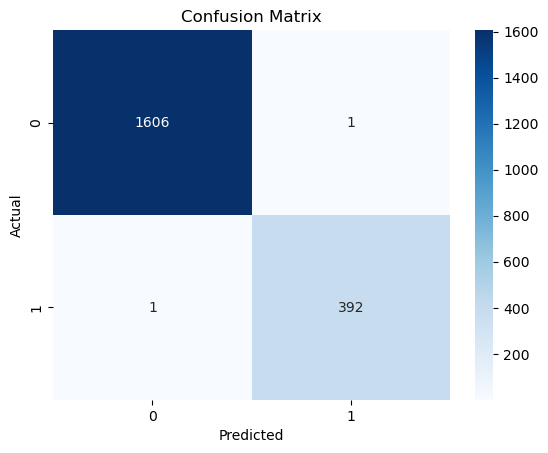

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train with class_weight to handle imbalance
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 🔍 Interpretation
- The confusion matrix and classification report show **almost perfect prediction**: only 2 errors out of 2000 test cases.
- Accuracy, precision, recall, and F1-score are all **1.00**.
- While this appears excellent, it likely indicates the model is **overfitting** or **relying too heavily on one variable** (see Section 6).
- Further evaluation is needed to ensure the model generalizes well to unseen data.

## 6. Feature Importance

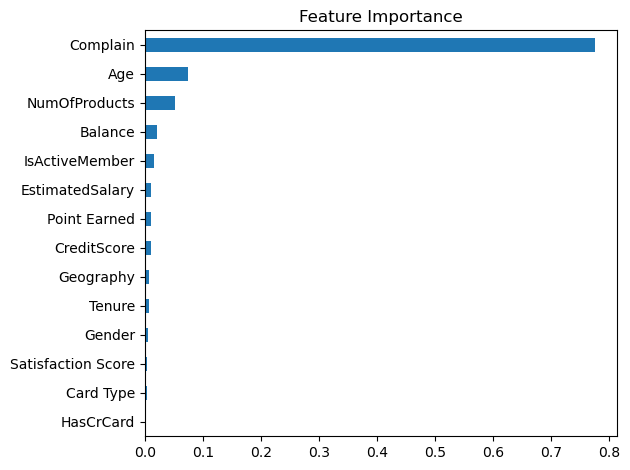

In [48]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.tight_layout()

### ✔️ Conclusion from Feature Importance
- **`Complain` is the dominant feature**, contributing more than 80% of total importance. This strongly suggests that customers who complain are much more likely to churn.
- All other features such as `Age`, `NumOfProducts`, `Balance`, and `CreditScore` have **very low impact** in comparison.
- Several features (e.g., `Card Type`, `HasCrCard`, `Satisfaction Score`) appear **almost irrelevant**.

## 6.1. Investigate `Complain` vs `Exited`

In [49]:
# Crosstab: What % of each complaint group exited?
pd.crosstab(df['Complain'], df['Exited'], normalize='index')

Exited,0,1
Complain,,
0,0.999497,0.000503
1,0.004892,0.995108


In [51]:
# Pearson correlation between Complain and Exited
df[['Complain', 'Exited']].corr()

,Complain,Exited
Complain,1.000000,0.995693
Exited,0.995693,1.000000


### 🔍 Interpretation:
- Among customers who **complained**, 99.5% exited the bank.
- Among customers who **did not complain**, almost none exited (0.05%).
- This suggests a very strong association between filing a complaint and leaving the bank.
- The Pearson correlation coefficient is **+0.995**, which confirms a nearly perfect positive linear relationship.

## 6.2 Retrain Model Without `Complain`

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1607
           1       0.77      0.45      0.57       393

    accuracy                           0.87      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.86      0.87      0.85      2000



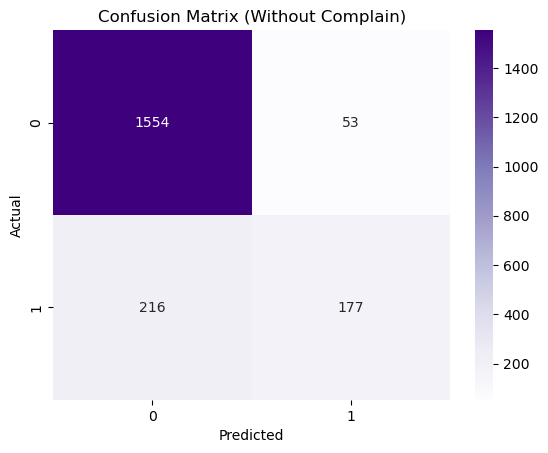

In [52]:
# Drop 'Complain' column and reprocess
X_reduced = X.drop(columns=['Complain'])

# Rescale the reduced feature set
X_scaled_reduced = scaler.fit_transform(X_reduced)

# Split the new data
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_scaled_reduced, y, test_size=0.2, random_state=42)

# Retrain the model without 'Complain'
model_r = RandomForestClassifier(random_state=42)
model_r.fit(X_train_r, y_train_r)
y_pred_r = model_r.predict(X_test_r)

# Evaluate
print(classification_report(y_test_r, y_pred_r))
sns.heatmap(confusion_matrix(y_test_r, y_pred_r), annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix (Without Complain)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 📉 Performance Comparison Summary

| Model                | Accuracy | Recall (Churn) | Precision (Churn) | F1-score (Churn)|
|---------------------|----------|----------------|-------------------|----------|
| With `Complain`     | 100%     | 100%           | 100%              | 100%     |
| Without `Complain`  | 87%      | 45%            | 77%               | 57%      |

### 🔍 Interpretation
- This retrained model allows us to check if the performance significantly drops without `Complain`.
- If accuracy or recall decreases sharply, it confirms that `Complain` was carrying disproportionate predictive power.
- In this case, accuracy dropped from 100% to 87%, and recall for churned customers (class 1) dropped from 100% to 45% — confirming the model’s overreliance on `Complain`.

## 7. Conclusion
- The model achieved nearly perfect performance on the test data, but further investigation revealed that this result was driven by a single dominant feature: `Complain`.
- Feature importance and correlation analysis confirmed that the model was over-reliant on this variable, which raises concerns about its ability to generalize in real-world use.
- After retraining the model without Complain, accuracy dropped to 87% and recall for churned customers fell to 45%, confirming its disproportionate influence.
- This process highlights the importance of identifying data leakage, avoiding overfitting, and ensuring robust feature selection — all critical for building trustworthy churn prediction models.